# SSMF-Task: Training of an SNN Demapper with Tenary Encoding

In this example we train SNN-based demapp with a single hidden LIF layer and a non-spiking integrator voting layer to solve the SSMF-Task [1]. The SNN demapper used in this example is based on [2].

### References
[1] Elias Arnold, Eike-Manuel Edelmann, Alexander von Bank, Eric Müller, Laurent Schmalen, Johannes Schemmel, Short-reach Optical Communications: A Real-world Task for Neuromorphic Hardware. [https://arxiv.org/abs/2412.03129](https://arxiv.org/abs/2412.03129)

[2] Eike-Manuel Bansbach; Alexander von Bank; Laurent Schmalen. Spiking Neural Network Decision Feedback Equalization. [https://ieeexplore.ieee.org/abstract/document/10104550](https://ieeexplore.ieee.org/abstract/document/10104550)


In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np
import torch
import norse.torch as norse

from IMDD import IMDDModel, SSMFDataset, helpers

## Tenary Encoding

In [5]:
dataset = SSMFDataset(train=True)

# Generate some data
y_chunk, q = dataset[45]

# Data
print("Received symbols y (chunked):\n\t", y_chunk, y_chunk.shape)
print("Corresponding index q:\n\t", q, q.shape)
print("Corresponding send bits:\n\t", helpers.get_graylabel(2)[q])

Received symbols y (chunked):
	 tensor([3.2442, 1.1051, 3.9311, 4.6754, 3.5988, 3.4377, 3.0124, 1.2034, 4.2148,
        5.0880, 4.3835, 3.3564, 3.6701, 2.9727, 2.4524, 4.9323, 2.4587, 0.8778,
        2.1116, 3.3859, 4.1223]) torch.Size([21])
Corresponding index q:
	 tensor(3) torch.Size([])
Corresponding send bits:
	 tensor([1, 0], dtype=torch.uint8)


In [6]:
# Word lenght of the quantizer
K = 8

# Maximum input value of the quantizer
x_max = 4

# Time resolution of encoding and SNN
dt = 1e-3
time_length = 0.01  # s

color = ["#FAC90F", "#FA8D0F", "#0F69FA", "#7A6F45"]

In [7]:
class BitMapper:
    """ Bit mapper class """

    def __init__(self, w, device):
        if(w <= 0):
            raise ValueError("w has to be larger than 0")
        self.device = device
        self.word_length = w
        self.change()

    def change(self):
        self.map_mat = torch.linspace(0, self.word_length - 1, self.word_length).to(self.device)
        self.map_mat = 2**self.map_mat

    def map(self, bits):
        numbers = self.map_mat @ torch.flip(bits, dims=[1]).T
        return numbers
 
    def demap(self, numbers):
        orig_shape = numbers.shape
        numbers = numbers.flatten()
        bit_list = [(numbers >> shift_ind) & 1 for shift_ind in range(self.word_length)] # little endian
        bit_list.reverse() # big endian
        bits = torch.zeros((self.word_length, numbers.shape[0]), device=self.device)
        for n in range(len(bit_list)):
            bits[n] = bit_list[n]
        bits = bits.T
        bits = bits.unflatten(0, (orig_shape))

        return bits


def midtread_binary_unipolar(x, w, x_max):
    x = torch.clip(x, 0, x_max)
    delta_x = x_max / (2**w)
    # Select class from +/- 2**w-1/2
    xh_uniform_midtread = torch.floor(torch.abs(x) / delta_x + 0.5)
    # Clip to 2**w-1
    xh_uniform_midtread = torch.clip(xh_uniform_midtread, 0, 2**w - 1)
    # Round up
    xh_uniform_midtread = torch.ceil(xh_uniform_midtread).int()

    return delta_x, xh_uniform_midtread

In [8]:
class Ternary_Encoder(torch.nn.Module):
    """ Class implementing the transmitter model """

    def __init__(self, word_length: int = 8, time: int = 10, maximum_input_absolute: int = 4,
                 device: torch.device ='cpu'):
        super().__init__()
        self.w = word_length
        self.T = time
        self.x_max = maximum_input_absolute
        self.bitmap = BitMapper(self.w, device)
        self.device = device

    def forward(self, recv_symbols):
        rx = recv_symbols - torch.mean(recv_symbols)
        d_x, recv_q = midtread_binary_unipolar(torch.abs(rx), self.w, self.x_max)
        binary = self.bitmap.demap(recv_q)
        sign = torch.permute(torch.sign(rx).repeat(self.w, 1, 1), (1, 2, 0))
        tern_in_sym = binary * sign
        inputs = tern_in_sym.reshape((1, tern_in_sym.shape[0], -1))
        inputs = torch.vstack(
            (inputs, torch.zeros(
                (self.T - 1, inputs.shape[1], inputs.shape[2]), device=self.device)))

        return inputs


encoder = Ternary_Encoder(
    word_length=K,
    time=int(time_length // dt),
    maximum_input_absolute=x_max,
    device='cpu')

In [9]:
spikes = encoder(y_chunk.unsqueeze(0))  # first ten samples
print("Spikes:\n", spikes, spikes.shape)

Spikes:
 tensor([[[-0., -0., -0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([10, 1, 168])


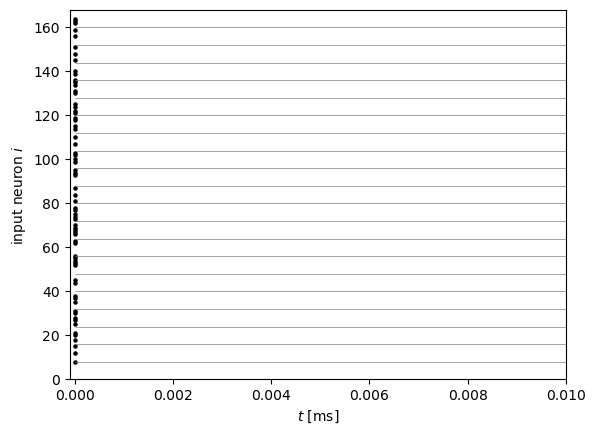

In [10]:
# Convert time-dense spikes into event-based spikes
events = torch.nonzero(spikes[:, 0])
time = np.linspace(0, time_length, int(time_length / dt))

fig, axes = plt.subplots()
axes.set_xlim(-0.0001, time_length)
axes.set_ylim(0, 21 * K)
axes.set_xlabel("$t$ [ms]")
axes.set_ylabel("input neuron $i$")
axes.scatter(events[:, 0] * dt, events[:, 1], s=5, color="black")
for i in range(21):
    axes.hlines(8 * (i + 1), 0, 0.015, color="grey", lw=0.5)
plt.show()

# Model

In [11]:
class SNNEqualizer(torch.nn.Module):

    def __init__(self, input_features: int, hidden_features: int, output_features: int,
                 encoder: torch.nn.Module, device: torch.device, dt: float = 0.001):
        super().__init__()

        self.device = device
        self.encoder = encoder
        self.dt = dt
        self.hidden_features = hidden_features
        self.output_features = output_features

        self.p = norse.LIFParameters(
            alpha=torch.zeros(hidden_features, device=device).fill_(1.0),
            v_th=torch.ones(hidden_features, device=device),
            v_leak=torch.tensor(0, device=device),
            v_reset=torch.zeros(hidden_features, device=device),
            tau_mem_inv=torch.zeros(hidden_features, device=device).fill_(100.0),
            tau_syn_inv=torch.zeros(hidden_features, device=device).fill_(200.0))

        self.linear_in = torch.nn.Linear(input_features, hidden_features, bias=False).to(device)
        self.LIFRec = norse.LIFRecurrentCell(
            hidden_features, hidden_features, p=self.p, dt=dt, autapses=False).to(device)
        self.linear_out = torch.nn.Linear(hidden_features, output_features, bias=True).to(device)

    @property
    def rate(self):
        return self.x.abs().sum(0).sum(1), self.z_rec.sum(0).sum(1)

    def forward(self, in_val):
        state = None
        self.x = self.encoder(in_val)

        z_rec, z_out = [], []
        for ts in range(self.x.shape[0]):
            z = self.linear_in(self.x[ts])
            z, state = self.LIFRec(z, state)
            z_rec.append(z)
            z = self.linear_out(z)
            z_out.append(z)

        self.z_rec = torch.stack(z_rec)
        z_out = torch.stack(z_out)

        z = torch.sum(z_out, 0)
        return z

## Helper Functions

In [12]:
def stats(loss: torch.Tensor, pred: torch.Tensor, data: torch.Tensor):
    ber = helpers.bit_error_rate(data, pred, False)
    acc = helpers.accuracy(data, pred, False)
    
    # Number false bits in current batch
    count = torch.count_nonzero(
        (gray_bits[torch.argmax(pred, 1)] != gray_bits[data]).reshape(-1))

    return ber, acc, count


def train(dataloader, optimizer, loss_fn, demapper, device):
    loss, acc, ber = [], [], []

    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        pred_b = demapper(data)
        loss_b = loss_fn(pred_b, target)

        # Optimize
        loss_b.backward()
        optimizer.step()

        # Get stats
        ber_b, acc_b, _ = stats(loss_b, pred_b, target)

        # Accumualte
        loss.append(loss_b.detach())
        acc.append(acc_b)
        ber.append(ber_b)

    return (torch.stack(loss).reshape(-1).mean(),
            torch.stack(acc).reshape(-1).mean(),
            torch.stack(ber).reshape(-1).mean())


def validate(dataloader, demapper, loss_fn, device, min_false_symbols, max_test_epochs):
    loss, acc, ber, n_false = [], [], [], 0

    for epoch in range(max_test_epochs):
        for i, (data, target) in enumerate(dataloader):

            data = data.to(device)
            target = target.to(device)

            pred_b = demapper(data)
            loss_b = loss_fn(pred_b, target)

            ber_b, acc_b, count = stats(loss_b, pred_b, target)

            loss.append(loss_b.detach())
            acc.append(acc_b)
            ber.append(ber_b)

            n_false += count

        if n_false >= min_false_symbols:
            break

    return (torch.stack(loss).reshape(-1).mean(),
            torch.stack(acc).reshape(-1).mean(),
            torch.stack(ber).reshape(-1).mean(),
            n_false)


def test(dataloader, demapper, device, min_false_bits):
    ber, i_rate, h_rate, n_false = [], [], [], 0
    while True:
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            pred_b = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)

            i_rate.append(lif_demapper.rate[0].detach())
            h_rate.append(lif_demapper.rate[1].detach())

            # Number false bits in current batch
            n_false += torch.count_nonzero(
                (gray_bits[torch.argmax(pred_b, 1)] != gray_bits[target]).reshape(-1))

        if n_false >= min_false_bits:
            break
    
    return (torch.stack(ber).reshape(-1).mean(),
            torch.stack(i_rate).reshape(-1).mean(),
            torch.stack(h_rate).reshape(-1).mean(),
            n_false)

## Training

In [13]:
# Paths
base_path = Path("imdd-task/example_results_final/SSMF/snr")
base_path.mkdir(exist_ok=True, parents=True)
model_dir = Path(base_path / "models")
model_dir.mkdir(exist_ok=True)

In [14]:
# The device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Training parameters
batch_size_train = 10000 
batch_size_val = 10000
epochs = 10000
#epochs = 100
min_false_bits = 2000
max_test_epochs = 1000
lr = 0.01

# Bits
gray_bits = helpers.get_graylabel(2).to(device)

Using device:  cuda


In [15]:
# Fix seed
torch.manual_seed(0)
np.random.seed(0)

# Demapper
lif_demapper = SNNEqualizer(
    input_features=K * 21,
    hidden_features=80,
    output_features=4,
    encoder=Ternary_Encoder(
        word_length=K,
        time=int(time_length // dt),
        maximum_input_absolute=x_max,
        device=device),
    device=device,
    dt=dt)

In [13]:
# Dataset
train_dataset = SSMFDataset()
# The SNRs we train the demapper for
train_dataset.set_noise_power_db(-17.)

# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size_val, shuffle=False)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)

# Train for SNR
val_data = torch.zeros((epochs // 10, 4))
best_val_ber = np.inf

# pbar = tqdm(total=epochs, unit="epoch", leave=False)
for epoch in range(epochs):
    # Train
    train_loss, train_acc, train_ber = train(train_loader, optimizer, loss_fn, lif_demapper, device)
    
    # Validate
    if epoch % 100 == 0:
        val_loss, val_acc, val_ber, n_false = validate(
            val_loader, lif_demapper, loss_fn, device, min_false_bits, max_test_epochs)

        # Save best demapper
        if val_ber < best_val_ber:
            torch.save(lif_demapper.state_dict(), model_dir / f"best_model_snr_17.pt")
            best_val_ber = val_ber
        print(f"Epoch {epoch}, train_ber: {train_ber.item()}, val_ber: {val_ber.item()}, n_false: {n_false.item()}")

Epoch 0, train_ber: 0.4940999746322632, val_ber: 0.5013999938964844, n_false: 10028
Epoch 100, train_ber: 0.046799998730421066, val_ber: 0.04370000213384628, n_false: 2622
Epoch 200, train_ber: 0.03804999962449074, val_ber: 0.03753333166241646, n_false: 2252
Epoch 300, train_ber: 0.03009999915957451, val_ber: 0.0325625017285347, n_false: 2605
Epoch 400, train_ber: 0.029199998825788498, val_ber: 0.02876249887049198, n_false: 2301
Epoch 500, train_ber: 0.02785000018775463, val_ber: 0.028474999591708183, n_false: 2278
Epoch 600, train_ber: 0.025949999690055847, val_ber: 0.026474999263882637, n_false: 2118
Epoch 700, train_ber: 0.030549999326467514, val_ber: 0.025737499818205833, n_false: 2059
Epoch 800, train_ber: 0.02484999969601631, val_ber: 0.023330001160502434, n_false: 2333
Epoch 900, train_ber: 0.02084999904036522, val_ber: 0.022419998422265053, n_false: 2242
Epoch 1000, train_ber: 0.023149998858571053, val_ber: 0.023660000413656235, n_false: 2366
Epoch 1100, train_ber: 0.0214999988

### Test

In [16]:
# SNRS to test the demapper
snrs = torch.arange(15., 24., 1.)
bers = np.zeros((snrs.shape[0], 5))

for s, snr in enumerate(snrs):
    # Set SNR in dataset
    # Dataset and loader
    dataset = SSMFDataset(train=False)
    dataset.set_noise_power_db(-snr.item())
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"best_model_snr_17.pt")
    lif_demapper.load_state_dict(state_dict)
    
    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)   
    bers[s] = torch.tensor([snr, ber, i_rate, h_rate, n_false]).cpu().numpy()

    print(f"Tested Demapper for {snr}. BER = {ber}, n_false = {n_false}")

np.save(base_path / "test_bers.npy", bers)

Tested Demapper for 15.0. BER = 0.0341000035405159, n_false = 2046
Tested Demapper for 16.0. BER = 0.02249000035226345, n_false = 2249
Tested Demapper for 17.0. BER = 0.01353750005364418, n_false = 2166
Tested Demapper for 18.0. BER = 0.007553571369498968, n_false = 2115
Tested Demapper for 19.0. BER = 0.003930768929421902, n_false = 2044
Tested Demapper for 20.0. BER = 0.0017798244953155518, n_false = 2029
Tested Demapper for 21.0. BER = 0.0006951724062673748, n_false = 2016
Tested Demapper for 22.0. BER = 0.0002289473486598581, n_false = 2001
Tested Demapper for 23.0. BER = 6.97560899425298e-05, n_false = 2002


## Plot BER-SNR curve

[208.65113831 208.55220032 208.83366394 209.09431458 209.00114441
 209.22547913 209.48358154 209.69190979]


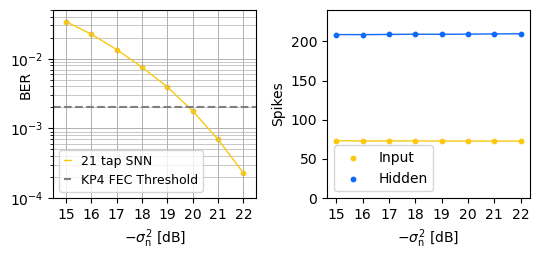

In [17]:
data = np.load(base_path / "test_bers.npy")[:-1]

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))
axs[0].set_ylabel("BER")
axs[0].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4, 5e-2)
axs[0].set_xlim(14.5, 22.5)
axs[0].set_xticks(data[:, 0])
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0], label=r"21 tap SNN")
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs[0].hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC Threshold")
axs[0].grid(which="minor", lw=0.5)
axs[0].grid(which="major", lw=0.7)
axs[0].yaxis.set_label_coords(-0.1, 0.6)
axs[0].legend(fontsize=9, handlelength=0.5)

axs[1].set_ylabel("Spikes")
axs[1].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[1].set_xticks(data[:, 0])
axs[1].set_ylim(0, 240)
axs[1].plot(data[:, 0], data[:, 2], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 2], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 3], color=color[2], s=10, label="Hidden")
axs[1].legend()

print(data[:, 3])

plt.tight_layout()
plt.savefig(base_path / "ber_snr.png")

## 2000 bit error events are enough

In [17]:
# We rerun the testing for 10 different seeds
bers = torch.zeros(10)

for seed in range(10):
    # Dataset and loader
    dataset = SSMFDataset(seed=seed)
    # Set SNR in dataset
    dataset.set_noise_power_db(-20.)
    
    # Dataloader
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"best_model_snr_17.pt")
    lif_demapper.load_state_dict(state_dict)
    lif_demapper.eval()

    # Test
    ber, _, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)
    bers[seed] = ber.cpu()
    
    print(f"Tested Demapper for Seed {seed}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")
    
np.save(base_path / "test_bers_20dB.npy", bers)

print(f"BER = {bers.mean()} +- {bers.std()}")

Tested Demapper for Seed 0. BER = 0.0017570173367857933, n_false = 2003, rate = 209.52053833007812
Tested Demapper for Seed 1. BER = 0.001661475282162428, n_false = 2027, rate = 209.49314880371094
Tested Demapper for Seed 2. BER = 0.001645901589654386, n_false = 2008, rate = 209.43368530273438
Tested Demapper for Seed 3. BER = 0.00170932209584862, n_false = 2017, rate = 209.5746612548828
Tested Demapper for Seed 4. BER = 0.0017482758266851306, n_false = 2028, rate = 209.4176483154297
Tested Demapper for Seed 5. BER = 0.0017937499796971679, n_false = 2009, rate = 209.46804809570312
Tested Demapper for Seed 6. BER = 0.0016354836989194155, n_false = 2028, rate = 209.471435546875
Tested Demapper for Seed 7. BER = 0.0016015872824937105, n_false = 2018, rate = 209.5956573486328
Tested Demapper for Seed 8. BER = 0.001703389803878963, n_false = 2010, rate = 209.5545654296875
Tested Demapper for Seed 9. BER = 0.0016590162413194776, n_false = 2024, rate = 209.5418701171875
BER = 0.00169152184389

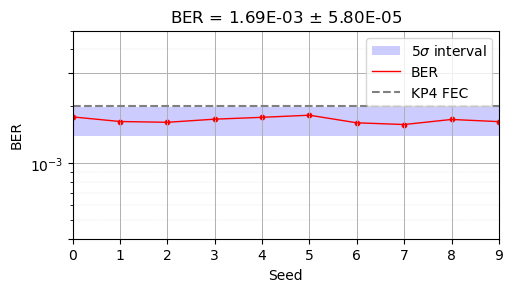

In [18]:
data = np.load(base_path / "test_bers_20dB.npy")

fig, axs = plt.subplots(ncols=1, figsize=(5.5, 2.7))
axs.set_ylabel("BER")
axs.set_xlabel("Seed")
axs.set_yscale("log")
axs.set_ylim(4e-4, 5e-3)
axs.set_xlim(0, 9)
axs.grid(which="minor", lw=0.2, ls=":")
axs.grid(which="major", lw=0.7)
axs.set_xticks(np.arange(10))
axs.set_yticks([4e-4, 1e-3, 3e-3])
axs.fill_between(
    np.arange(10),
    np.full(10, data.mean()) - 5 * data.std(),
    np.full(10, data.mean()) + 5 * data.std(), lw=1, facecolor="blue", alpha=0.2, label=r"$5\sigma$ interval")
axs.plot(np.arange(10), data, lw=1, color="red", label=r"BER")
axs.scatter(np.arange(10), data, color="red", s=10)
axs.hlines(2e-3, 0, 9, color="grey", ls="--", label="KP4 FEC")
axs.set_title(f"BER = {data.mean():.2E} $\pm$ {data.std():.2E}")
axs.legend()

## Sweep Hidden Size as -20dB

Now we repeat the procedure but instead we keep the noise level constant at required value and sweep the number of neurons in the hidden layer. 

In [18]:
# Train demapper on independet data
base_path = Path("./imdd-task/example_results_final/SSMF/hidden_size")
base_path.mkdir(exist_ok=True, parents=True)
model_dir = base_path / "models"
model_dir.mkdir(exist_ok=True, parents=True)

### Train

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()

for n_hidden in [5, 10, 15, 20, 30, 40, 60, 80, 100]:
    print(f"n_hidden: {n_hidden}")

    # reset seed
    torch.manual_seed(0)
    np.random.seed(0)

    lif_demapper = SNNEqualizer(
        input_features=K * 21,  # n_taps * word_lenght
        hidden_features=n_hidden,
        output_features=4,  # len(alphabet)
        encoder=Ternary_Encoder(
        word_length=K,
        time=int(time_length // dt),
        maximum_input_absolute=x_max,
        device=device),
        device=device,
        dt=dt)

    # Dataset
    dataset = SSMFDataset()
    # We train at 20dB only
    dataset.set_noise_power_db(-20)

    # Dataloader
    train_loader = torch.utils.data.DataLoader(dataset, batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)

    # train for SNR
    best_val_ber = np.inf
    for epoch in range(epochs):
        train_loss, train_acc, train_ber = train(
            train_loader, optimizer, loss_fn, lif_demapper, device)
        if epoch % 100 == 0:
            val_loss, val_acc, val_ber, n_false = validate(
                val_loader, lif_demapper, loss_fn, device, min_false_bits,
                max_test_epochs)

            # Save best Demapper
            if val_ber < best_val_ber:
                torch.save(
                    lif_demapper.state_dict(), model_dir / f"n_hidden_{n_hidden}.pt")
                best_val_ber = val_ber

            print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                + f"n_false={n_false}")

n_hidden: 5
Epoch=0, val_loss=1.8958, val_ber=0.5033000, val_acc=0.2445, n_false=10066
Epoch=100, val_loss=0.6402, val_ber=0.1450500, val_acc=0.7137, n_false=2901
Epoch=200, val_loss=0.2119, val_ber=0.0495167, val_acc=0.9010, n_false=2971
Epoch=300, val_loss=0.1525, val_ber=0.0335167, val_acc=0.9330, n_false=2011
Epoch=400, val_loss=0.1362, val_ber=0.0255375, val_acc=0.9489, n_false=2043
Epoch=500, val_loss=0.1277, val_ber=0.0237800, val_acc=0.9525, n_false=2378
Epoch=600, val_loss=0.1201, val_ber=0.0208900, val_acc=0.9582, n_false=2089
Epoch=700, val_loss=0.1274, val_ber=0.0242900, val_acc=0.9514, n_false=2429
Epoch=800, val_loss=0.1162, val_ber=0.0256625, val_acc=0.9487, n_false=2053
Epoch=900, val_loss=0.1134, val_ber=0.0205900, val_acc=0.9588, n_false=2059
Epoch=1000, val_loss=0.1286, val_ber=0.0237800, val_acc=0.9524, n_false=2378
Epoch=1100, val_loss=0.1198, val_ber=0.0212100, val_acc=0.9576, n_false=2121
Epoch=1200, val_loss=0.1130, val_ber=0.0200200, val_acc=0.9600, n_false=200

### Test

In [19]:
# Test demapper on independent data for different hidden sizes
datas = np.zeros((9, 5))

for s, n_hidden in enumerate([5, 10, 15, 20, 30, 40, 60, 80, 100]):

    lif_demapper = SNNEqualizer(
        input_features=K * 21,# n_taps * word_length
        hidden_features=n_hidden,
        output_features=4,# len(alphabet)
        encoder=Ternary_Encoder(
        word_length=K,
        time=int(time_length // dt),
        maximum_input_absolute=x_max,
        device=device),
        device=device,
        dt=dt)

    # Dataset and loader
    dataset = SSMFDataset(train=False)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"n_hidden_{n_hidden}.pt")
    lif_demapper.load_state_dict(state_dict)

    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)
    datas[s] = torch.tensor([n_hidden, ber, n_false, i_rate, h_rate]).cpu().numpy()

    print(f"Tested Demapper for {n_hidden}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")

    np.save(base_path / "test_bers.npy", datas)

Tested Demapper for 5. BER = 0.013256249018013477, n_false = 2121, rate = 19.988075256347656
Tested Demapper for 10. BER = 0.0076214284636080265, n_false = 2134, rate = 44.669700622558594
Tested Demapper for 15. BER = 0.005177500192075968, n_false = 2071, rate = 59.13263702392578
Tested Demapper for 20. BER = 0.004441304598003626, n_false = 2043, rate = 86.45548248291016
Tested Demapper for 30. BER = 0.003238709643483162, n_false = 2008, rate = 126.72868347167969
Tested Demapper for 40. BER = 0.002955714240670204, n_false = 2069, rate = 152.32823181152344
Tested Demapper for 60. BER = 0.0022288889158517122, n_false = 2006, rate = 211.3037872314453
Tested Demapper for 80. BER = 0.0019259615801274776, n_false = 2003, rate = 223.5039825439453
Tested Demapper for 100. BER = 0.0017866073176264763, n_false = 2001, rate = 256.74462890625


### Plot BER-Hidden Size Curve

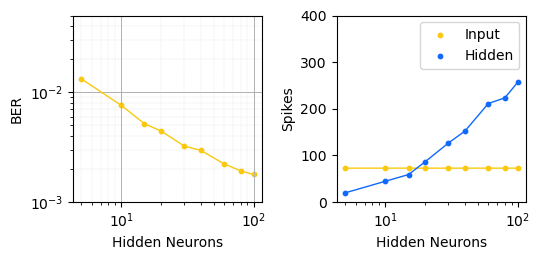

In [20]:
data = np.load(base_path / "test_bers.npy")

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))

axs[0].set_ylabel("BER")
axs[0].set_xlabel("Hidden Neurons")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].grid(which="minor", lw=0.2, ls=":")
axs[0].grid(which="major", lw=0.7)
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0])
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs[0].set_ylim(1e-3, 5e-2)

axs[1].set_ylabel("Spikes")
axs[1].set_xscale("log")
axs[1].set_xlabel("Hidden Neurons")
axs[1].set_ylim(0, 400)
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 3], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 4], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 4], color=color[2], s=10, label="Hidden")
axs[1].legend()

plt.tight_layout()
plt.savefig(base_path / "ber_hidden_size.png")

## Sweep $n_\text{taps}$ at -20 dB 

In [21]:
# Train demapper
base_path = Path("./imdd-task/example_results_final/SSMF/n_taps")
base_path.mkdir(exist_ok=True, parents=True)
model_dir = base_path / "models"
model_dir.mkdir(exist_ok=True, parents=True)

ths = [1, 1, 1, 1, 1, 1, 1, 1, 1]
taps = [5, 11, 16, 21, 31, 41, 61, 81, 101]

loss_fn = torch.nn.CrossEntropyLoss()

### Train

In [14]:
for v_th, n_taps in zip(ths, taps):
    print(f"n_taps: {n_taps}")

    # reset seed
    torch.manual_seed(0)
    np.random.seed(0)

    lif_demapper = SNNEqualizer(
        input_features=K * n_taps,# n_taps * word_lenght
        hidden_features=80,
        output_features=4,# len(alphabet)
        encoder=Ternary_Encoder(
        word_length=K,
        time=int(time_length // dt),
        maximum_input_absolute=x_max,
        device=device),
        device=device,
        dt=dt)

    # Dataset
    dataset = SSMFDataset()
    dataset.set_n_taps(n_taps)
    # update SNR in Dataset
    dataset.set_noise_power_db(-20.)

    # Dataloader
    train_loader = torch.utils.data.DataLoader(dataset, batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=True)

    optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)

    # train for SNR
    best_val_ber = np.inf
    for epoch in range(epochs):
        train_loss, train_acc, train_ber = train(
            train_loader, optimizer, loss_fn, lif_demapper,
            device)
        if epoch % 100 == 0:
            val_loss, val_acc, val_ber, n_false = validate(
                val_loader, lif_demapper, loss_fn, device, min_false_bits, max_test_epochs)

            # Save best Demapper
            if val_ber < best_val_ber:
                torch.save(lif_demapper.state_dict(), model_dir / f"n_taps_{n_taps}.pt")
                best_val_ber = val_ber

            print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                + f"n_false={n_false}")

n_taps: 5
Epoch=0, val_loss=1.4457, val_ber=0.5014000, val_acc=0.2508, n_false=10028
Epoch=100, val_loss=0.1964, val_ber=0.0402500, val_acc=0.9195, n_false=2415
Epoch=200, val_loss=0.1453, val_ber=0.0288500, val_acc=0.9423, n_false=2308
Epoch=300, val_loss=0.1093, val_ber=0.0211300, val_acc=0.9578, n_false=2113
Epoch=400, val_loss=0.1002, val_ber=0.0189417, val_acc=0.9621, n_false=2273
Epoch=500, val_loss=0.0836, val_ber=0.0161286, val_acc=0.9677, n_false=2258
Epoch=600, val_loss=0.0845, val_ber=0.0159929, val_acc=0.9680, n_false=2239
Epoch=700, val_loss=0.0656, val_ber=0.0120833, val_acc=0.9759, n_false=2175
Epoch=800, val_loss=0.0655, val_ber=0.0120611, val_acc=0.9759, n_false=2171
Epoch=900, val_loss=0.0650, val_ber=0.0126625, val_acc=0.9748, n_false=2026
Epoch=1000, val_loss=0.0547, val_ber=0.0103050, val_acc=0.9795, n_false=2061
Epoch=1100, val_loss=0.0585, val_ber=0.0110050, val_acc=0.9781, n_false=2201
Epoch=1200, val_loss=0.0515, val_ber=0.0095636, val_acc=0.9809, n_false=2104


### Test

In [22]:
# Test demapper on independent data for different n_taps
datas = np.zeros((9, 5))

for s, (v_th, n_taps) in enumerate(zip(ths, taps)):
    lif_demapper = SNNEqualizer(
        input_features=K * n_taps,# n_taps * word_lenght
        hidden_features=80,
        output_features=4,# len(alphabet)
        encoder=Ternary_Encoder(
        word_length=K,
        time=int(time_length // dt),
        maximum_input_absolute=x_max,
        device=device),
        device=device,
        dt=dt)

    # Dataset and loader
    dataset = SSMFDataset(train=False)
    dataset.set_n_taps(n_taps)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"n_taps_{n_taps}.pt")
    lif_demapper.load_state_dict(state_dict)
    
    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)
    datas[s] = torch.tensor([n_taps, ber, n_false, i_rate, h_rate]).cpu().numpy()

    print(f"Tested Demapper for n_taps = {n_taps}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")

    np.save(base_path / "test_bers.npy", datas)

Tested Demapper for n_taps = 5. BER = 0.007396428380161524, n_false = 2071, rate = 226.9199981689453
Tested Demapper for n_taps = 11. BER = 0.002219565212726593, n_false = 2042, rate = 223.73568725585938
Tested Demapper for n_taps = 16. BER = 0.0020479592494666576, n_false = 2007, rate = 243.38027954101562
Tested Demapper for n_taps = 21. BER = 0.0019278846448287368, n_false = 2005, rate = 216.41738891601562
Tested Demapper for n_taps = 31. BER = 0.001995098078623414, n_false = 2035, rate = 227.51605224609375
Tested Demapper for n_taps = 41. BER = 0.002143617020919919, n_false = 2015, rate = 236.03395080566406
Tested Demapper for n_taps = 61. BER = 0.0023290696553885937, n_false = 2003, rate = 236.47518920898438
Tested Demapper for n_taps = 81. BER = 0.0024487804621458054, n_false = 2008, rate = 237.95071411132812
Tested Demapper for n_taps = 101. BER = 0.002429761691018939, n_false = 2041, rate = 254.624755859375


### Plot $n_\text{taps}$-BER Curve

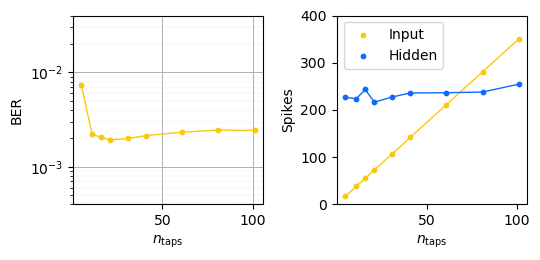

In [24]:
data = np.load(base_path / "test_bers.npy")

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))

axs[0].set_ylabel("BER")
axs[0].set_yticks([1e-3, 5e-4])
axs[0].set_xlabel("$n_\mathrm{taps}$")
axs[0].set_ylim(4e-4, 4e-2)
axs[0].set_yscale("log")
axs[0].grid(which="minor", lw=0.2, ls=":")
axs[0].grid(which="major", lw=0.7)
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0])
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)

axs[1].set_ylabel("Spikes")
axs[1].set_xlabel("$n_\mathrm{taps}$")
axs[1].set_ylim(0, 400)
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 3], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 4], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 4], color=color[2], s=10, label="Hidden")
axs[1].legend()

plt.tight_layout()
plt.savefig(base_path / "n_taps_ber.png")